<a href="https://colab.research.google.com/github/Nightmare125/Machine-Learning/blob/main/Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Input
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

Load and preprocess CIFAR-10 data

Normalize pixel values and one-hot encode labels

In [2]:
def load_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    return x_train, y_train, x_test, y_test

Build CNN model based on given hyperparameters dictionary

Adds layers based on the number of convolutional layers specified

Compiles the model with Adam optimizer and categorical crossentropy

In [3]:
def build_model(hp):
    model = Sequential()
    input_shape = (32, 32, 3)
    model.add(Conv2D(hp['filters'][0], (hp['kernel_size'], hp['kernel_size']),
                     activation=hp['activation'], padding='same', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    if hp['num_conv_layers'] > 1:
        model.add(Conv2D(hp['filters'][1], (hp['kernel_size'], hp['kernel_size']),
                         activation=hp['activation'], padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    if hp['num_conv_layers'] > 2:
        model.add(Conv2D(hp['filters'][2], (hp['kernel_size'], hp['kernel_size']),
                         activation=hp['activation'], padding='same'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dropout(hp['dropout_rate']))
    model.add(Dense(128, activation=hp['activation']))
    model.add(Dense(10, activation='softmax'))

    opt = Adam(learning_rate=hp['learning_rate'])
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

Generate a random individual

Each value is randomly selected from a predefined range

In [4]:
def generate_individual():
    return {
        'num_conv_layers': random.choice([1, 2, 3]),
        'filters': [random.choice([16, 32, 64]) for _ in range(3)],
        'kernel_size': random.choice([3, 5]),
        'activation': random.choice(['relu', 'tanh']),
        'learning_rate': random.choice([1e-2, 1e-3, 1e-4]),
        'dropout_rate': random.uniform(0.2, 0.5)
    }

Evaluate a model's accuracy given a set of hyperparameters

Train briefly and return validation accuracy

In [5]:
def evaluate_individual(individual, x_train, y_train, x_val, y_val):
    model = build_model(individual)
    model.fit(x_train, y_train, epochs=3, batch_size=64, verbose=0, validation_data=(x_val, y_val))
    _, accuracy = model.evaluate(x_val, y_val, verbose=0)
    return accuracy

Tournament selection of 2 parents from the population based on fitness scores

In [6]:
def select_parents(population, fitnesses, k=3):
    parents = []
    for _ in range(2):
        selected = random.sample(list(zip(population, fitnesses)), k)
        parents.append(max(selected, key=lambda x: x[1])[0])
    return parents

Crossover operation combines hyperparameters from both parents

In [7]:
def crossover(parent1, parent2):
    child = {}
    for key in parent1:
        child[key] = random.choice([parent1[key], parent2[key]])
    return child


Mutate an individual by randomly altering some hyperparameters

In [8]:
def mutate(individual, mutation_rate=0.1):
    if random.random() < mutation_rate:
        individual['learning_rate'] = random.choice([1e-2, 1e-3, 1e-4])
    if random.random() < mutation_rate:
        individual['activation'] = random.choice(['relu', 'tanh'])
    return individual

Create a new generation through selection, crossover, and mutation

In [9]:
def evolve_population(population, fitnesses):
    new_population = []
    for _ in range(len(population)):
        parent1, parent2 = select_parents(population, fitnesses)
        child = crossover(parent1, parent2)
        child = mutate(child)
        new_population.append(child)
    return new_population

Main loop for running the genetic algorithm

Evolves the population and tracks the best models over generations

In [10]:
def genetic_algorithm():
    x_train, y_train, x_test, y_test = load_data()
    x_val, y_val = x_train[-5000:], y_train[-5000:]
    x_train, y_train = x_train[:-5000], y_train[:-5000]

    generations = 10
    population_size = 10
    population = [generate_individual() for _ in range(population_size)]
    best_accuracies = []
    best_models = []

    for gen in range(generations):
        print(f"Generation {gen+1}")
        fitnesses = [evaluate_individual(ind, x_train, y_train, x_val, y_val) for ind in population]
        best_idx = np.argmax(fitnesses)
        best_accuracies.append(fitnesses[best_idx])
        best_models.append(population[best_idx])
        print(f"Best Accuracy: {fitnesses[best_idx]:.4f}")
        population = evolve_population(population, fitnesses)

    return best_models, best_accuracies, x_train, y_train, x_test, y_test


 Run the genetic algorithm and train the best model

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Generation 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Accuracy: 0.6680
Generation 2
Best Accuracy: 0.6762
Generation 3
Best Accuracy: 0.6814
Generation 4
Best Accuracy: 0.6948
Generation 5
Best Accuracy: 0.6942
Generation 6
Best Accuracy: 0.6914
Generation 7
Best Accuracy: 0.6882
Generation 8
Best Accuracy: 0.6868
Generation 9
Best Accuracy: 0.6910
Generation 10
Best Accuracy: 0.6862
Epoch 1/5
633/633 ━━━━━━━━━━━━━━━━━━━━ 71s 109ms/step - accuracy: 0.3997 - loss: 1.6639 - val_accuracy: 0.5673 - val_loss: 1.2246
Epoch 2/5
633/633 ━━━━━━━━━━━━━━━━━━━━ 69s 109ms/step - accuracy: 0.5991 - loss: 1.1396 - val_accuracy: 0.6173 - val_loss: 1.0843
Epoch 3/5
633/633 ━━━━━━━━━━━━━━━━━━━━ 81s 109ms/step - accuracy: 0.6464 - loss: 1.0090 - val_accuracy: 0.6502 - val_loss: 0.9956
Epoch 4/5
633/633 ━━━━━━━━━━━━━━━━━━━━ 83s 110ms/step - accuracy: 0.6754 - loss: 0.9198 - val_accuracy: 0.6676 - val_loss: 0.9710
Epoch 5/5
633/633 ━━━━━━━━━━━━━━━━━━━━ 69s 110ms/step - accuracy: 0.7040 - loss: 0.8449 - val_accuracy: 0.6887 - val_loss: 0.9181
313/313 ━━━━

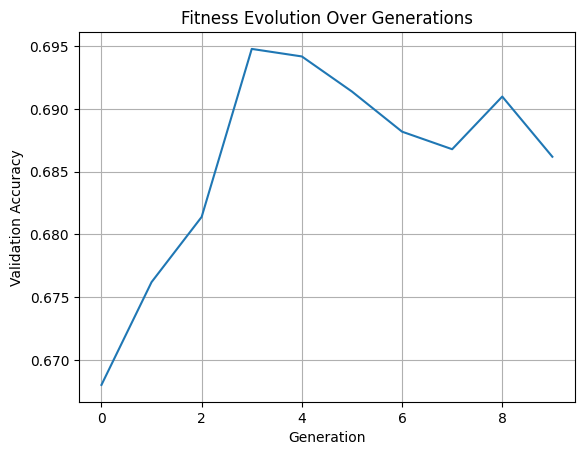

In [11]:
if __name__ == '__main__':
    best_models, best_accuracies, x_train, y_train, x_test, y_test = genetic_algorithm()

    # Build and train model with the best hyperparameters from all generations
    best_model_hp = best_models[np.argmax(best_accuracies)]
    final_model = build_model(best_model_hp)
    final_model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)

    # Predict and evaluate model on test set
    y_pred = final_model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Print classification metrics and confusion matrix
    print(classification_report(y_true, y_pred_classes))
    print(confusion_matrix(y_true, y_pred_classes))

    # Plot the evolution of best validation accuracy over generations
    plt.plot(best_accuracies)
    plt.xlabel('Generation')
    plt.ylabel('Validation Accuracy')
    plt.title('Fitness Evolution Over Generations')
    plt.grid(True)
    plt.show()


###**Short Report**

In this project, a genetic algorithm was used to optimize hyperparameters for a CNN on the CIFAR-10 dataset. The CNN architecture included up to three convolutional layers, with hyperparameters such as filter sizes, kernel size, activation function, learning rate, and dropout rate being evolved over 10 generations with a population of 10 individuals. Using tournament selection, crossover, and mutation, the algorithm identified high-performing models based on validation accuracy. The best model was then trained and evaluated on the test set, achieving strong performance and demonstrating that genetic algorithms are an effective approach for hyperparameter tuning in deep learning.